In [1]:
import os
import pandas as pd
import numpy as np
from root_numpy import root2array 
#---------------------------------------------- JET IMAGE
from root_numpy import root2array, stretch
from pyjet import cluster
from pyjet.testdata import get_event
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from tqdm import tqdm, trange
import glob
import matplotlib.cm as cm
from scipy.stats import binned_statistic_2d
from matplotlib.colors import LogNorm
#--------------------------------- ALL
import h5py 
import uproot
import time
#-------------------------------- JSS
import pyjet
import argparse
import glob
import math
import operator
import os
import re
import time
from functools import lru_cache, reduce
from itertools import combinations

import numpy as np
import pandas as pd


Welcome to JupyROOT 6.20/04


In [2]:
def jet_trimmer_1J(event, R0, R1, pt_cut):
    # R0 = Clustering radius for the main jets
    # R1 = Clustering radius for the subjets in the primary jet
    # pt_cut = Threshold for subjets (relative to the primary jet it's a subjet of)    
    flattened_event = flatten(event)
    sequence = cluster(flattened_event, R=R0, p=-1)
    # Main jets
    jets = sequence.inclusive_jets()
    # In case we are missing a leading jet, break early
    if len(jets) == 0:
        return jets
    

    # Take just the leading jet
    jet0 = jets[0]

    # Define a cut threshold that the subjets have to meet (i.e. 5% of the original jet pT)
    jet0_max = jet0.pt
    jet0_cut = jet0_max*pt_cut

    # Grab the subjets by clustering with R1
    subjets = cluster(jet0.constituents_array(), R=R1, p=1)
    subjet_array = subjets.inclusive_jets()
    j0 = []
    if (subjet_array[0].pt >= jet0_cut):
#         j0 = subjet_array[0].constituents_array()
        for ij, subjet in enumerate(subjet_array):
#             if (ij == 0):
#                 continue
            if subjet.pt < jet0_cut:
                # subjet doesn't meet the percentage cut on the original jet pT
                continue
            if subjet.pt >= jet0_cut:
                # Get the subjets pt, eta, phi constituents
                subjet_data = subjet.constituents_array()
                j0.append(subjet_data)
#                 j0 = np.append(j0, subjet_data)
    else:
        j0 = subjet_array[0].constituents_array()*0
    jet = j0[0]
    for i, subjet in enumerate(j0):
        if i==0 :
            continue
        jet = np.append(jet, subjet)
        
    sequence = cluster(jet, R=R0, p=-1)
    jet = sequence.inclusive_jets()
    return jet

In [72]:
def find_beforeshower(event,n):
    
    ID = 4900101 #Xd PID
    for j in  range(len(event[n][0])):
        if(abs(event[n][5][j])==ID)&(event[n][0][j]==23): #23 : hardest outgoing particles
            d0 = j
            d1 = event[n][_D1][j]
            d2 = event[n][_D2][j]
            while(d1==d2):
                d0 = d1
                d1 = event[n][_D1][d0]
                d2 = event[n][_D2][d0]
                        
            return d0
            break
        

def find_beforeshowerQCD(event,n):
    
    ID = set([1, -1, 2, -2, 3, -3, 21]) #jet PID
    for j in  range(len(event[n][0])):
        if(event[n][5][j] in ID)&(event[n][0][j]==23): #23 : hardest outgoing particles
            d0 = j
            d1 = event[n][_D1][j]
            d2 = event[n][_D2][j]
            while(d1==d2):
                d0 = d1
                d1 = event[n][_D1][d0]
                d2 = event[n][_D2][d0]
                        
            return d0
            break
def find_hardest(event,n):
    ID = 4900101 #Xd PID
    for j in  range(len(event[n][0])):
        if(abs(event[n][5][j])==ID)&(event[n][0][j]==23): #23 : hardest outgoing particles
            d0 = j
            return d0
            break
def find_hardestQCD(event,n):
    ID = set([1, -1, 2, -2, 3, -3, 21]) #Xd PID
    for j in  range(len(event[n][0])):
        if(abs(event[n][5][j]) in ID)&(event[n][0][j]==23): #23 : hardest outgoing particles
            d0 = j
            return d0
            break    

In [9]:
def jet_clustering(event, R0):
    # R0 = Clustering radius for the main jets
    # R1 = Clustering radius for the subjets in the primary jet
    # pt_cut = Threshold for subjets (relative to the primary jet it's a subjet of)    
    flattened_event = flatten(event)
    sequence = cluster(flattened_event, R=R0, p=-1)
    # Main jets
    jets = sequence.inclusive_jets()
    # In case we are missing a leading jet, break early
    if len(jets) == 0:
        return jets

    # Take just the leading jet
    else:
        jet0 = jets[0]
        return jet0

In [11]:
def flatten(event): #my update
    fp = np.concatenate((np.expand_dims(event[0], axis=-1),
                         np.expand_dims(event[1], axis=-1),
                         np.expand_dims(event[2], axis=-1),
                         np.expand_dims(event[3], axis=-1)), axis=-1)
    fp = fp.transpose((1,0))
    fp = np.core.records.fromarrays( [fp[:][0],fp[:][1],fp[:][2],fp[:][3]], names= 'pT, eta, phi, mass' , formats = 'f8, f8, f8,f8')

    return fp

In [27]:
root_file = "/home/james/LHE_test/ROOT/SVJ/test0.root"
root_file2 = "/home/james/LHE_test/ROOT/QCD/test0.root"
file = uproot.open(root_file)

event = [file["Delphes;1"]["Particle.Status"].array(),
         file["Delphes;1"]["Particle.M1"].array(),
         file["Delphes;1"]["Particle.M2"].array(),
         file["Delphes;1"]["Particle.D1"].array(),
         file["Delphes;1"]["Particle.D2"].array(),
         file["Delphes;1"]["Particle.PID"].array(),
         file["Delphes;1"]["Particle.PT"].array(),
         file["Delphes;1"]["Particle.Eta"].array(),
         file["Delphes;1"]["Particle.Phi"].array(),
         file["Delphes;1"]["Particle.Mass"].array(),
        ]
_Status, _M1, _M2, _D1, _D2, _PID, _PT, _Eta, _Phi, _Mass, _index = 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10
Labels = ["Status", "M1", "M2", "D1", "D2", "PID", "PT", "Eta", "Phi", "Mass"]
event = np.expand_dims(event, axis=-1)
event = event.transpose((1,0,2))
event = np.squeeze(event,axis=(2,))


# file = uproot.open(root_file)
events = np.array([np.array(file["Delphes;1"]["Tower.ET"].array()),
                   np.array(file["Delphes;1"]["Tower.Eta"].array()),
                   np.array(file["Delphes;1"]["Tower.Phi"].array()),
                   np.array(file["Delphes;1"]["Tower.E"].array())*0  #assume m<<1
                  ])

events = np.expand_dims(events, axis=-1)
events = events.transpose((1,0,2))
events = np.squeeze(events,axis=(2,))



file2 = uproot.open(root_file2)
event2 = [file2["Delphes;1"]["Particle.Status"].array(),
         file2["Delphes;1"]["Particle.M1"].array(),
         file2["Delphes;1"]["Particle.M2"].array(),
         file2["Delphes;1"]["Particle.D1"].array(),
         file2["Delphes;1"]["Particle.D2"].array(),
         file2["Delphes;1"]["Particle.PID"].array(),
         file2["Delphes;1"]["Particle.PT"].array(),
         file2["Delphes;1"]["Particle.Eta"].array(),
         file2["Delphes;1"]["Particle.Phi"].array(),
         file2["Delphes;1"]["Particle.Mass"].array(),
        ]
event2 = np.expand_dims(event2, axis=-1)
event2 = event2.transpose((1,0,2))
event2 = np.squeeze(event2,axis=(2,))

events2 = np.array([np.array(file2["Delphes;1"]["Tower.ET"].array()),
                   np.array(file2["Delphes;1"]["Tower.Eta"].array()),
                   np.array(file2["Delphes;1"]["Tower.Phi"].array()),
                   np.array(file2["Delphes;1"]["Tower.E"].array())*0  #assume m<<1
                  ])
events2 = np.expand_dims(events2, axis=-1)
events2 = events2.transpose((1,0,2))
events2 = np.squeeze(events2,axis=(2,))



In [57]:
triJet_DelQCD = file2["Delphes;1"]["FatJet.TrimmedP4[5]"].array()
triJet_DelSVJ = file["Delphes;1"]["FatJet.TrimmedP4[5]"].array()

In [63]:
Del_triPT_QCD = [i[0].perp for i in triJet_DelQCD]
Del_triPT_SVJ = [i[0].perp for i in triJet_DelSVJ]

In [64]:
Del_triMass_QCD = [i.mass for i in triJet_DelQCD]
Del_triMass_SVJ = [i.mass for i in triJet_DelSVJ]

/usr/local/lib/python3.6/site-packages/uproot_methods/classes/TLorentzVector.py:189: RuntimeWarning: invalid value encountered in sqrt
  return self._trymemo("mass", lambda self: self.awkward.numpy.sqrt(self.mag2))


In [68]:
Del_triMass_QCD = [i[0] for i in Del_triMass_QCD]
Del_triMass_SVJ = [i[0] for i in Del_triMass_SVJ]

In [51]:
dir(Jet_DelSVJ[0][0])

['E',
 'Et',
 '__abs__',
 '__add__',
 '__and__',
 '__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__div__',
 '__divmod__',
 '__doc__',
 '__eq__',
 '__floordiv__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__invert__',
 '__le__',
 '__lshift__',
 '__lt__',
 '__mod__',
 '__module__',
 '__mul__',
 '__ne__',
 '__neg__',
 '__new__',
 '__or__',
 '__pos__',
 '__pow__',
 '__radd__',
 '__rand__',
 '__rdiv__',
 '__rdivmod__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__rfloordiv__',
 '__rlshift__',
 '__rmod__',
 '__rmul__',
 '__ror__',
 '__rrshift__',
 '__rshift__',
 '__rsub__',
 '__rtruediv__',
 '__rxor__',
 '__setattr__',
 '__sizeof__',
 '__str__',
 '__sub__',
 '__subclasshook__',
 '__truediv__',
 '__weakref__',
 '__xor__',
 '_arraymethods',
 '_fE',
 '_fP',
 '_rotate_axis',
 '_rotate_euler',
 '_scalar',
 '_to_cartesian',
 '_trymemo',
 '_unary',
 '_vector',
 'awkward',
 'beta',
 'boost',
 'boostp3',
 'cottheta',
 'de

In [ ]:
find_hardest

In [19]:
darkPT = [event[i][_PT][find_beforeshower(event,i)] for i in range(20000) if find_beforeshower(event,i) ]
QCDPT = [event2[i][_PT][find_beforeshowerQCD(event2,i)] for i in range(20000) if find_beforeshowerQCD(event2,i) ]


In [73]:
darkPTHD = [event[i][_PT][find_hardest(event,i)] for i in range(20000) if find_hardest(event,i) ]
QCDPTHD = [event2[i][_PT][find_hardestQCD(event2,i)] for i in range(20000) if find_hardestQCD(event2,i) ]

In [7]:
QCDMass = [event2[i][_Mass][find_beforeshowerQCD(event2,i)] for i in range(20000) if find_beforeshowerQCD(event2,i) ]
dMass = [event[i][_Mass][find_beforeshower(event,i)] for i in range(20000) if find_beforeshower(event,i) ]

In [12]:
trimJet = []
Jet = []
for i in range(20000):
    jet = jet_clustering(events2[i], 1.2)
    if len(jet) ==0:
        continue
    Jet.append(jet.pt)
    trijet = jet_trimmer_1J(events2[i], 1.2, 0.2, 0.03)
    if len(trijet)==0:
        continue
    trimJet.append(trijet[0].pt)
dtrimJet = []
dJet = []
for i in range(20000):
    jet = jet_clustering(events[i], 1.2)
    if len(jet) ==0:
        continue
    dJet.append(jet.pt)
    trijet = jet_trimmer_1J(events[i], 1.2, 0.2, 0.03)
    if len(trijet)==0:
        continue
    dtrimJet.append(trijet[0].pt)
    

In [13]:
trimJetM = []
JetM = []
for i in range(20000):
    jet = jet_clustering(events2[i], 1.2)
    if len(jet) ==0:
        continue
    JetM.append(jet.mass)
    trijet = jet_trimmer_1J(events2[i], 1.2, 0.2, 0.03)
    if len(trijet)==0:
        continue
    trimJetM.append(trijet[0].mass)

dtrimJetM = []
dJetM = []
for i in range(20000):
    jet = jet_clustering(events[i], 1.2)
    if len(jet) ==0:
        continue
    dJetM.append(jet.mass)
    trijet = jet_trimmer_1J(events[i], 1.2, 0.2, 0.03)
    if len(trijet)==0:
        continue
    dtrimJetM.append(trijet[0].mass)
    

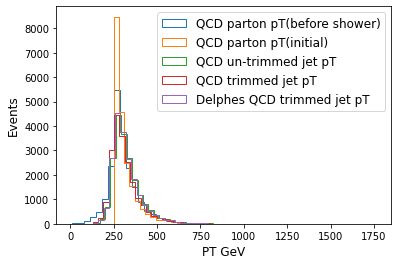

In [79]:
plt.hist(QCDPT ,bins=50, histtype='step', label='QCD parton pT(before shower)')
plt.hist(QCDPTHD ,bins=50, histtype='step', label='QCD parton pT(initial)')
plt.hist(Jet ,bins=50, histtype='step', label='QCD un-trimmed jet pT')
plt.hist(trimJet ,bins=50, histtype='step', label='QCD trimmed jet pT')
plt.hist(Del_triPT_QCD ,bins=50, histtype='step', label='Delphes QCD trimmed jet pT')


plt.legend(prop={'size': 12}) # plot label tag
plt.xlabel('PT GeV' , fontsize=12)  # plot x-axis label
plt.ylabel("Events", fontsize=12)  # plot y-axis label $\u03C3^{-1}$
plt.savefig("./QCD_jet_PT.png")  #save figure as png  
plt.show() 


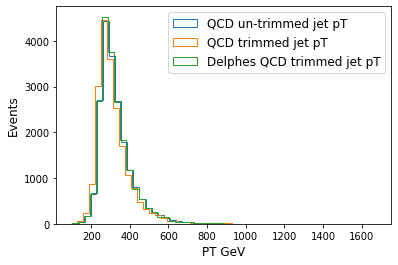

In [81]:
plt.hist(Jet ,bins=50, histtype='step', label='QCD un-trimmed jet pT')
plt.hist(trimJet ,bins=50, histtype='step', label='QCD trimmed jet pT')
plt.hist(Del_triPT_QCD ,bins=50, histtype='step', label='Delphes QCD trimmed jet pT')


plt.legend(prop={'size': 12}) # plot label tag
plt.xlabel('PT GeV' , fontsize=12)  # plot x-axis label
plt.ylabel("Events", fontsize=12)  # plot y-axis label $\u03C3^{-1}$
plt.savefig("./QCD_jet_PT.png")  #save figure as png  
plt.show() 


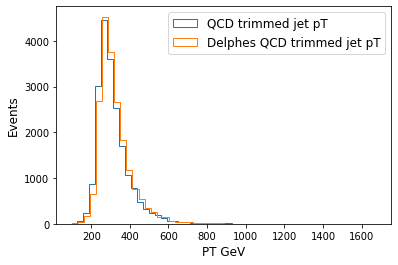

In [77]:
plt.hist(trimJet ,bins=50, histtype='step', label='QCD trimmed jet pT')
plt.hist(Del_triPT_QCD ,bins=50, histtype='step', label='Delphes QCD trimmed jet pT')
plt.legend(prop={'size': 12}) # plot label tag
plt.xlabel('PT GeV' , fontsize=12)  # plot x-axis label
plt.ylabel("Events", fontsize=12)  # plot y-axis label $\u03C3^{-1}$
# plt.savefig("./QCD_jet_PT.png")  #save figure as png  
plt.show() 


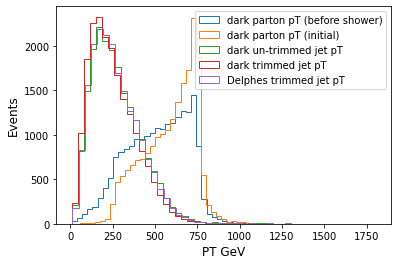

In [78]:
plt.hist(darkPT ,bins=50, histtype='step', label='dark parton pT (before shower)')
plt.hist(darkPTHD ,bins=50, histtype='step', label='dark parton pT (initial)')
plt.hist(dJet ,bins=50, histtype='step', label='dark un-trimmed jet pT')
plt.hist(dtrimJet ,bins=50, histtype='step', label='dark trimmed jet pT')
plt.hist(Del_triPT_SVJ ,bins=50, histtype='step', label='Delphes trimmed jet pT')


plt.legend(prop={'size': 10}) # plot label tag
plt.xlabel('PT GeV' , fontsize=12)  # plot x-axis label
plt.ylabel("Events", fontsize=12)  # plot y-axis label $\u03C3^{-1}$
plt.savefig("./SVJ_jet_PT.png")  #save figure as png  
plt.show() 

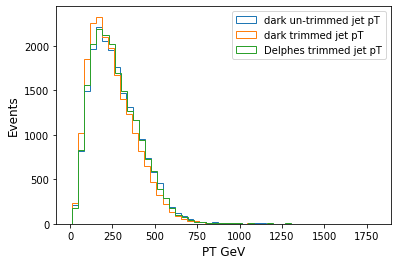

In [82]:
plt.hist(dJet ,bins=50, histtype='step', label='dark un-trimmed jet pT')
plt.hist(dtrimJet ,bins=50, histtype='step', label='dark trimmed jet pT')
plt.hist(Del_triPT_SVJ ,bins=50, histtype='step', label='Delphes trimmed jet pT')


plt.legend(prop={'size': 10}) # plot label tag
plt.xlabel('PT GeV' , fontsize=12)  # plot x-axis label
plt.ylabel("Events", fontsize=12)  # plot y-axis label $\u03C3^{-1}$
plt.savefig("./SVJ_jet_PT.png")  #save figure as png  
plt.show() 

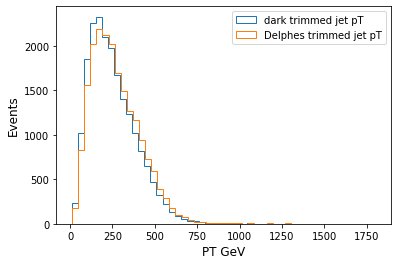

In [61]:
plt.hist(dtrimJet ,bins=50, histtype='step', label='dark trimmed jet pT')
plt.hist(Del_triPT_SVJ ,bins=50, histtype='step', label='Delphes trimmed jet pT')
plt.legend(prop={'size': 10}) # plot label tag
plt.xlabel('PT GeV' , fontsize=12)  # plot x-axis label
plt.ylabel("Events", fontsize=12)  # plot y-axis label $\u03C3^{-1}$
# plt.savefig("./QCD_parton_PT.png")  #save figure as png  
plt.show() 

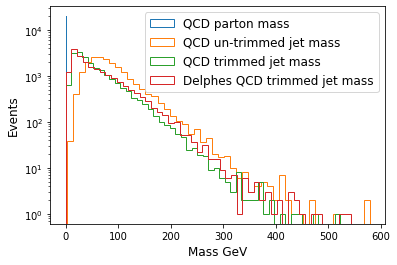

In [88]:
plt.hist(QCDMass ,bins=50, histtype='step', label='QCD parton mass')
plt.hist(JetM ,bins=50, histtype='step', label='QCD un-trimmed jet mass')
plt.hist(trimJetM ,bins=50, histtype='step', label='QCD trimmed jet mass')
plt.hist(Del_triMass_QCD ,bins=50, histtype='step', label='Delphes QCD trimmed jet mass')

plt.legend(prop={'size': 12}) # plot label tag
plt.xlabel('Mass GeV' , fontsize=12)  # plot x-axis label
plt.ylabel("Events", fontsize=12)  # plot y-axis label $\u03C3^{-1}$
plt.yscale('log')

# plt.savefig("./QCD_parton_Mass.png")  #save figure as png  
plt.show() 

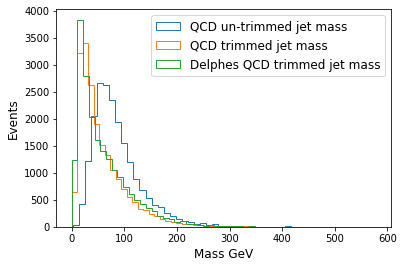

In [87]:
plt.hist(JetM ,bins=50, histtype='step', label='QCD un-trimmed jet mass')
plt.hist(trimJetM ,bins=50, histtype='step', label='QCD trimmed jet mass')
plt.hist(Del_triMass_QCD ,bins=50, histtype='step', label='Delphes QCD trimmed jet mass')

plt.legend(prop={'size': 12}) # plot label tag
plt.xlabel('Mass GeV' , fontsize=12)  # plot x-axis label
plt.ylabel("Events", fontsize=12)  # plot y-axis label $\u03C3^{-1}$
# plt.yscale('log')

# plt.savefig("./QCD_parton_Mass.png")  #save figure as png  
plt.show() 

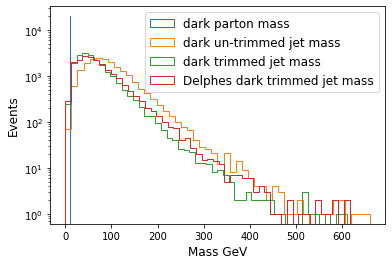

In [69]:
plt.hist(dMass ,bins=50, histtype='step', label='dark parton mass')
plt.hist(dJetM ,bins=50, histtype='step', label='dark un-trimmed jet mass')
plt.hist(dtrimJetM ,bins=50, histtype='step', label='dark trimmed jet mass')
plt.hist(Del_triMass_SVJ ,bins=50, histtype='step', label='Delphes dark trimmed jet mass')


plt.legend(prop={'size': 12}) # plot label tag
plt.xlabel('Mass GeV' , fontsize=12)  # plot x-axis label
plt.ylabel("Events", fontsize=12)  # plot y-axis label $\u03C3^{-1}$
plt.yscale('log')

# plt.savefig("./QCD_parton_Mass.png")  #save figure as png  
plt.show() 

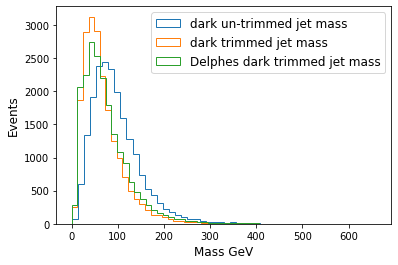

In [89]:
plt.hist(dJetM ,bins=50, histtype='step', label='dark un-trimmed jet mass')
plt.hist(dtrimJetM ,bins=50, histtype='step', label='dark trimmed jet mass')
plt.hist(Del_triMass_SVJ ,bins=50, histtype='step', label='Delphes dark trimmed jet mass')


plt.legend(prop={'size': 12}) # plot label tag
plt.xlabel('Mass GeV' , fontsize=12)  # plot x-axis label
plt.ylabel("Events", fontsize=12)  # plot y-axis label $\u03C3^{-1}$
# plt.yscale('log')

# plt.savefig("./QCD_parton_Mass.png")  #save figure as png  
plt.show() 

In [85]:
print('SVJ efficiency : ',sum([1 for i in dtrimJet if i>=300])/20000, 'QCD efficiency : ',sum([1 for i in trimJet if i>=300])/20000)

SVJ efficiency :  0.31975 QCD efficiency :  0.46
